In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import itertools
import pandas as pd
import random
from collections import Counter
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from tqdm import tqdm
import string
import matplotlib.pyplot as plt

%matplotlib inline

# Read files and put all together 

In [3]:
%%time
data_path = ''
data = pd.read_csv(data_path + 'christmas-books.csv')['Title']

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 14.3 ms


# Preprocessing: data selection

In [4]:
# Remove empty texts
data = data[~(data=='')]

# Ensure no nulls and no empty
assert sum(data=='')==0
assert sum(data.isnull())==0

Number of books: 1905


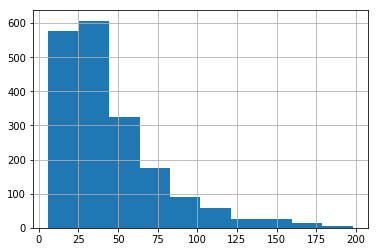

In [5]:
# Remove very long carols
length_threshold=200
data = data[data.apply(len)<length_threshold]
data.apply(len).hist()
print("Number of books: %d" %len(data))

# Preprocessing: data cleaning

In [6]:
# Lowercase
data = data.apply(lambda x: x.lower())


In [7]:
# get some samples from the training corpus

for i in range(10):
    print(random.choice(list(data)))
    print('-----')

christ and christmas, a poem
-----
a christmas mystery;
-----
the year of christ in song: advent and christmas-tide
-----
a christmas carol in prose
-----
teledyne ryan achiever, dec. 1991
-----
christmas greetings and other verses
-----
the religious souvenir: a christmas, new year's and birth day present
-----
uncle toby's christmas book, for all the family;
-----
christmas carols and hymns for school and choir
-----
winter diets
-----


# Create tokens and encode train and validation set

In [8]:
# Create token_dict based on ascii letters
all_letters = string.ascii_letters[0:26] + """ ".,;'-+=?!$%():\n"""
token_dict = {token:k for token,k in zip(all_letters, range(1,len(all_letters)+1))}

end_token = '<end>'
pad_token = '<pad>'

token_dict[pad_token] = 0
token_dict[end_token] = len(token_dict)

decoder_dict = {token_dict[k]:k for k in token_dict.keys()}
tokens_count = len(token_dict)
assert len(decoder_dict)==len(decoder_dict)
tokens_count

45

In [9]:
def text_encoder(text):
    return [token_dict[token] for token in text if token in token_dict] + [token_dict['<end>']]

%time data_encoded =  list( data.apply(text_encoder) ) # as a list is much faster to retrieve elements

CPU times: user 64 ms, sys: 60 ms, total: 124 ms
Wall time: 45.4 ms


# Define model

In [10]:
class RNN(nn.Module):
    def __init__(self, 
                 tokens_count,
                 embedding_dimension, 
                 rnn_dim,
                 #relu_dim,
                 num_layers, 
                 dropout):
        
        super(RNN, self).__init__()
        
        self.rnn_dim = rnn_dim
        
        self.embedding = nn.Embedding(tokens_count, embedding_dimension)
        self.lstm = nn.LSTM(input_size = embedding_dimension, 
                            hidden_size = rnn_dim, 
                            num_layers = num_layers, 
                            dropout = dropout,
                            batch_first = True)
        #self.linear_1 =  nn.Linear(rnn_dim , relu_dim) 
        #self.relu_1 = nn.ReLU()
        #self.linear_2 =  nn.Linear(relu_dim , tokens_count)
        #self.relu_2 = nn.ReLU()
        
        self.linear = nn.Linear(rnn_dim,tokens_count)
        self.dropout = nn.Dropout(dropout)
        self.logsoftmax = nn.LogSoftmax(dim=2)

    def forward(self, inp, seq_length, hidden_states, train=True):
        embedded = self.embedding(inp)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, seq_length, batch_first=True)
        packed_output, (ht, ct) = self.lstm(packed_embedded, hidden_states)
        (lstm_output, length) = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
#         output_linear_1 = self.linear_1(lstm_output)
#         output_relu_1 = self.relu_1(output_linear_1)
#         output_linear_2 = self.linear_2(output_relu_1)
#         output_relu_2 = self.relu_2(output_linear_2)
        
        output_linear = self.linear(lstm_output)
        if train: output = self.dropout(output_linear)
        output = self.logsoftmax(output_linear)
        return output, (ht, ct)

    def initRNN(self, batch_size):
        if use_cuda:
            return (Variable(torch.zeros(num_layers, batch_size, self.rnn_dim).cuda()), 
                Variable(torch.zeros(num_layers, batch_size, self.rnn_dim)).cuda())
        else:
            return (Variable(torch.zeros(num_layers, batch_size, self.rnn_dim)), 
                Variable(torch.zeros(num_layers, batch_size, self.rnn_dim)))


In [11]:
use_cuda = True
embedding_dimension = 256
num_layers = 2
rnn_dim = 512
#relu_dim = 256

dropout = 0.1
batch_size = 16

In [ ]:
if use_cuda:
    rnn = RNN(tokens_count, embedding_dimension, rnn_dim, num_layers, dropout).cuda()
else:
    rnn = RNN(tokens_count, embedding_dimension, rnn_dim, num_layers, dropout)
loss_function = nn.NLLLoss(ignore_index=token_dict[pad_token])
optimizer = torch.optim.Adam(rnn.parameters())
learning_rate = 0.0005

In [ ]:
# Total number of parameters
parameters_count=0
for a in rnn.parameters():
    parameters_count+=len(a.view(-1))
print("Parameters count: %d" %parameters_count)
rnn.named_parameters

Parameters count: 3712813


<bound method Module.named_parameters of RNN(
  (embedding): Embedding(45, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=512, out_features=45, bias=True)
  (dropout): Dropout(p=0.1)
  (logsoftmax): LogSoftmax()
)>

In [ ]:
def get_lengths(v):
    return np.array([i for i in map(len, v)])

def pad(v):
    lens = np.array([len(item) for item in v])
    mask = lens[:,None] > np.arange(lens.max())
    out = np.zeros(mask.shape,dtype=int)
    out[mask] = np.concatenate(v)
    return out

losses = []
step_count = 0

In [ ]:
# load previously trained model
# rnn.load_state_dict(torch.load('../models/model.pickle'))

In [ ]:
def generates_sequence(start_string, max_length, stat_select=True):
    
    input_encoded = []
    for char in start_string:
        input_encoded.append(token_dict[char])

    top_index = 0
    result = start_string
    hidden = rnn.initRNN(1)
    
    if use_cuda:
        input_var =Variable(torch.cuda.LongTensor([input_encoded]))
    else:
        input_var = Variable(torch.LongTensor([input_encoded]))
    
    while input_encoded[0] != token_dict['<end>']:
    
        
        output, hidden = rnn(input_var,
                              np.array([len(input_encoded)]), 
                              hidden ,
                              train = True)
        
        if stat_select:
            selected = int(np.where((torch.cumsum(torch.exp(output.view(-1)),0) > random.random()).data)[0].min())
        else:
            selected = int(output.cpu().data.topk(1,dim=2)[1].numpy()[0][-1])

        input_encoded = [selected]
       
        result+=decoder_dict[input_encoded[0]]
        
        if len(result)==max_length: break
        
        if use_cuda:
            input_var = Variable(torch.cuda.LongTensor(input_encoded)).view(1,1)
        else:
            input_var = Variable(torch.LongTensor(input_encoded)).view(1,1)
        
    return result

print(generates_sequence('chris', 1000))

chris!t uihg=+c )-+ i<pad>
!n+w-jymw=vl<pad>h:q"n'owu;aarfz
hc+'a=:<end>


In [ ]:
while True:
    random.shuffle(data_encoded)
    batches = np.array_split(data_encoded, int(len(data_encoded)/batch_size))
    
    for batch in batches:

        # Prepare batch input and target (sort and pad)
        batch = list(batch)
        batch.sort(key=len, reverse=True)

        batch_input = [i[:-1] for i in batch]
        batch_target = [i[1:] for i in batch]

        batch_input_pad = pad(batch_input)
        batch_target_pad = pad(batch_target)

        # Forward pass and loss function
        if use_cuda:
            input_var = Variable(torch.cuda.LongTensor(batch_input_pad))
        else:
            input_var = Variable(torch.LongTensor(batch_input_pad))
        
        output, _ = rnn(input_var, get_lengths(batch_input), 
                                  rnn.initRNN(len(batch_input)) ,
                                  train = True)
        flat_output = output.contiguous().view(-1,tokens_count)
        if use_cuda:
            flat_target = Variable(torch.cuda.LongTensor(batch_target_pad.flatten()))
        else:
            flat_target = Variable(torch.LongTensor(batch_target_pad.flatten()))
        loss = loss_function(flat_output , flat_target)  # loss is already averaged
        losses.append(float(loss))
        
        # Optimise
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
               
        if step_count%20 == 0:
            print(step_count)
            generate = generates_sequence(random.choice(string.ascii_letters[0:26]), 500)
            print(generate)
            print('Original:', sum(data == generate[:-5])==0)
            print('-----')
            
        step_count+=1

0
j<end>
Original: True
-----
20
z'?
koormcas yor rrtstere<end>
Original: True
-----
40
xferild<end>
Original: True
-----
60
vey caroms<end>
Original: True
-----
80
br.y boris<end>
Original: True
-----
100
x)tant sond limfelalas afce jomy of a thy derevic deranon the negron; spacole aners yes<end>
Original: True
-----
120
oksest of sulle<end>
Original: True
-----
140
b-"for christmas cqudcten christmas in at lundiegs-chuat scarle<end>
Original: True
-----
160
k%estory dreel" ..<end>
Original: True
-----
180
omeck younday an other level<end>
Original: True
-----
200
dig whel cald the carding a bocket ard leever's fit lternifor christmas necrimen<end>
Original: True
-----
220
geng junnew taden of minen farimigs crinturting comosiese quato christmas, degas<end>
Original: True
-----
240
rying<end>
Original: True
-----
260
lomern mury carols ..<end>
Original: True
-----
280
glaed christmas castor book of the christmas-carol, "how stied in prosont<end>
Original: True
-----
300
uspial and new

In [ ]:
for i in range(10):
    print(generates_sequence('team', 500))
    print('---')